In [ ]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules


!pip install --quiet --upgrade jsonschema
!pip install --quiet git+https://github.com/yoseflab/scvi-tools@pierre/DE
!pip install --quiet plotnine
!pip install 'scanpy[leiden]'

In [1]:
%matplotlib inline

import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9

from scvi.external import WSCVI
from scvi.model import SCVI
from scvi.data import setup_anndata
import logging
import scvi
import matplotlib
import torch

bin_cmap = matplotlib.colors.ListedColormap(["grey", "black"])
# sc.set_figure_params(scanpy=False, dpi=300)

In [2]:
fn_kwargs = dict(
    max_chunks=5, 
    n_cells_per_chunk=50,
    marginal_n_samples_per_pass=250,
    n_mc_samples_px=500,
    do_filter_cells=True,
)

In [3]:
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt


def get_pefdr(y_pred, fdr_target=0.05) -> tuple:
    """
    Computes posterior expected FDR
    """
    sorted_genes = np.argsort(-y_pred)
    sorted_pgs = y_pred[sorted_genes]
    cumulative_fdr = (1.0 - sorted_pgs).cumsum() / (1.0 + np.arange(len(sorted_pgs)))

    n_positive_genes = (cumulative_fdr <= fdr_target).sum()
    pred_de_genes = sorted_genes[:n_positive_genes]
    is_pred_de = np.zeros_like(cumulative_fdr).astype(bool)
    is_pred_de[pred_de_genes] = True
    return cumulative_fdr

def plot_fdr(is_significant_de, preds):
    true_fdr_arr = true_fdr(y_true=is_significant_de, y_pred=preds)
    pe_fdr_arr, y_decision_rule = posterior_expected_fdr(y_pred=preds)
    return true_fdr_arr, pe_fdr_arr
    

def get_true_fdr(y_true, y_pred):
    """
    Computes GT FDR
    """
    n_genes = len(y_true)
    probas_sorted = np.argsort(-y_pred)
    true_fdr_array = np.zeros(n_genes)
    for idx in range(1, len(probas_sorted) + 1):
        y_pred_tresh = np.zeros(n_genes, dtype=bool)
        where_pos = probas_sorted[:idx]
        y_pred_tresh[where_pos] = True
        # print(y_pred_tresh)
        true_fdr_array[idx - 1] = 1.0 - precision_score(y_true, y_pred_tresh)
    return true_fdr_array


The purpose of this notebook is to motivate and introduce lvm-DE's main features for Differential Expression (DE).
After motivating its motivation for detecting DE genes on simulated data, we illustrate hypothesis testing and gene ranking features on a COVID dataset of PBMC cells from six healthy controls and seven infected patients (*Wilk et al. 2020*)

# Introducing lvm-DE

## Differential expression in scVI
<!-- In a similar fashion than the change mode of scVI, that we here denote as scVI-change, lvm-DE formulates composite null hypotheses for differential expression for each gene $g$, -->
The change mode of scVI, that we here denote as scVI-change, fomulates composite null hypotheses for differential expression for each gene $g$,
\begin{align}
\mathcal{H}^g_0:
\left \vert \log_2  \frac{h_A^g}{h_B^g} \right \vert \geq \delta,
\end{align}
where $h_A^g, h_B^g$ are normalized expression levels of subpopulations A and B.

Hence, to detect differentially expressed genes, scVI-change works as follows.
First, it approximates the LFC between the two populations,
scVI-change relies on the aggregated variational posterior to (i). obtain latent samples $z_i$ (ii). associate them to expression levels $h_i$, such that 
\begin{align*}
    \begin{cases}
        z_i^A \sim \frac{1}{\vert \mathcal{I}_A \vert}
        \sum_{n \in \mathcal{I}_A} \mathcal{Q}(x_n) \\
        h_i^A = f_h(z).
        \label{eq:plugin}
        \tag{plugin}
    \end{cases}
\end{align*}
Here, $\mathcal{Q}(x_n)$ denote the variational distribution of cell $x_n$, which is a Gaussian random variable whose mean and variance are parameterized by neural networks of $x_n$.
Sampling expression levels $h^A_i, h^B_i$ suffice to compute the DE probability, that we denote $p^g$.

Second, scVI-change converts DE probabilities to decisions, i.e., to a list of tagged DE genes.
To do so, scVI-change uses posterior expectations of the Posterior Expected Proportion (FDP), in the hope to provide False Discovery Rate (FDR)-calibrated DE gene predictions.


## Main differences introduced by  lvm-DE

To provide a more general and suitable way to do differential expression, we introduce lvm-DE, which provides improved FDR control for DE.
lvm-DE has a lot of common ground with scVI-change.
In particular, it uses the same hypotheses, and also rely on posterior expectations to control the FDR.

There are however two main differences between original scVI-change and lvm-DE, that both improve the ability of the procedure to provide meaningful DE genes.

##### No-hyperparameter and more understandable DE 
lvm-DE no longer requires to provide user-specified parameters for differential expression.
provides a data-driven procedure to select the effect-size thresold $\delta$, that can be difficult to setup in practical applications. Using pseudo-counts, it also filters out DE genes of very low expression. 

##### A better aggregation of individual cells to capture subpopulation-level gene expression
scVI-change and lvm-DE **differ in the way subpopulation expression levels are computed from scVI's inference and generative models**.
scVI-change's DE procedure sometime fails to control the FDR, because it might not properly aggregate subpopulation cell observations (in Equation \ref{eq:plugin}).
Same as before, lvm-DE relies on a pool of $N$ posterior samples $z_1, \dots z_N$ using the aggregated posterior of Equation \ref{eq:plugin}.
However, we now resort on importance-sampling, such that each sample $z_i$ now has a weight $w_i$
\begin{align}
    w_i \propto
    p(z_i)
    \frac
    {
    \sum_{n \in \mathcal{I}_A} p(x_n \mid z_i) / p(x_n)
    }
    {\sum_{n \in \mathcal{I}_A} q(z_i \mid x_n)}.
    \label{eq:is}
    \tag{reweighting}
\end{align}
In practice, this formulation can favor posterior samples with high-likelihood for many cells of the subpopulation.

This last point has important implications for FDR control.
Indeed, an important restriction of the scVI-change used in scVI is that it may not effectively control the FDR on synthetic data.
To illustrate this point, we consider a 10X-like dataset from five populations generated using SymSim (*Zhang et al., 2019*), and focus on the comparison of two of these subpopulations.

## Data import and model training

In [4]:
symsim_adata = ad.read_h5ad("./symsim_data.h5ad")

Next, we train two scVI-based models, `SCVI`, that we are going to use for DE using scVI-change, and `WSCVI`, that will be used for lvm-DE.
However, we emphasize that lvm-DE is **model-agnostic**, and could hence be applied to `SCVI` model, but would require code changes.

In [5]:
model = SCVI(adata=symsim_adata)
model.train(max_epochs=500, batch_size=1024, plan_kwargs=dict(lr=0.001, weight_decay=1e-4, eps=0.01))

wmodel = WSCVI(adata=symsim_adata)
wmodel.train(max_epochs=500, batch_size=1024, plan_kwargs=dict(lr=0.001, weight_decay=1e-4, eps=0.01))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 500/500: 100%|██████████| 500/500 [00:45<00:00, 11.04it/s, loss=596, v_num=1] 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]



Epoch 500/500: 100%|██████████| 500/500 [00:50<00:00,  9.91it/s, loss=604, v_num=1] 


In [6]:
# Comparing cell-types 2 and 3 using scVI-change
de_res = model.differential_expression(
    adata=symsim_adata,
    groupby="cts", 
    group1="2",
    group2="3", 
    delta=None,
).merge(symsim_adata.var, left_index=True, right_index=True)

DE...: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Performing DE using lvm-DE follows the same logic than with the original scVI function.

In [7]:
# Comparing cell-types 2 and 3 using lvm-DE
wde_res = wmodel.lvm_de(
    adata=symsim_adata,
    groupby="cts", 
    group1="2",
    group2="3", 
    delta=None,
    pseudocounts=None,
    batch_correction=True,
    fn_kwargs=fn_kwargs,
    n_samples=20000,
).merge(symsim_adata.var, left_index=True, right_index=True)

DE...: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


In order to compare the ability of both of these approaches to provide FDR-calibrated decisions, we plot the FDR as well as the posterior expected FDP, of the decision consisting in tagging as DE the $k$ genes with the highest DE probability.

In [8]:
true_fdr_lvm = get_true_fdr(
    wde_res.is_significant_de.values, 
    wde_res.proba_de.values
)
pe_fdr_lvm = get_pefdr(wde_res.proba_de.values)

true_fdr = get_true_fdr(
    de_res.is_significant_de.values, 
    de_res.proba_de.values
)
pe_fdr = get_pefdr(de_res.proba_de.values)

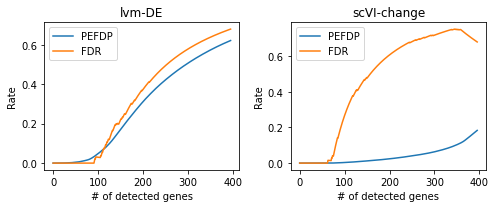

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3), sharex=True)
plt.sca(axes[1])
plt.plot(pe_fdr, label="PEFDP")
plt.plot(true_fdr, label="FDR")
plt.xlabel("# of detected genes")
plt.ylabel("Rate")
plt.title("scVI-change")
plt.legend()

plt.sca(axes[0])
plt.plot(pe_fdr_lvm, label="PEFDP")
plt.plot(true_fdr_lvm, label="FDR")
plt.xlabel("# of detected genes")
plt.ylabel("Rate")
plt.title("lvm-DE")
plt.legend()
plt.tight_layout()

We observe that lvm-DE posterior expected FDR more closely match the ground-truth than scVI-change, hinting that it can provide much more calibrated decisions than scVI-change.


Next, we illustrate lvm-DE's potential for various DE scenarios in a large-scale multibatched dataset 

# Application to real data

## Extracting data and training scVI

we now consider a 10X PBMC (dataset)[https://www.nature.com/articles/s41591-020-0944-y] from six healthy donors and seven COVID patients (*Wilk et al., 2020*), containing in total ~45K cells.
Because of the size of the original dataset, which can be found (here)[https://www.covid19cellatlas.org/index.patient.html], we here provide a preprocessed dataset, containing raw counts and 3,000 genes filtered using Seurat V3.

In [13]:
# Loading and preprocessing 10X data
main_data_url = "https://github.com/PierreBoyeau/gitdata/blob/main/lvm-DE-notebook/blish_data.h5ad?raw=true"
adata_ = sc.read("blish_data2.h5ad", backup_url=main_data_url)
obs = adata_.obs
setup_anndata(adata_, batch_key="Donor_full", labels_key="cell_type_fine")

INFO     Using batches from adata.obs["Donor_full"]                                          
INFO     Using labels from adata.obs["cell_type_fine"]                                       
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 44721 cells, 3000 vars, 14        
         batches, 20 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


We first train scVI with importance sampling.

In [18]:
model = WSCVI(adata=adata_)
model.train(batch_size=1024, max_epochs=250, train_size=1.0, plan_kwargs=dict(lr=1e-3))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 250/250: 100%|██████████| 250/250 [12:34<00:00,  3.02s/it, loss=794, v_num=1]


## Plotting data

First, we visualize the latent representation of the model with scanpy's UMAP visualization tool.

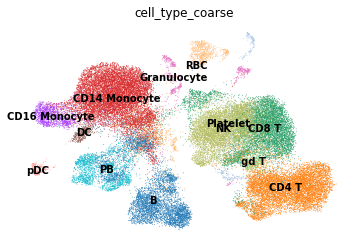

In [19]:
latent = model.get_latent_representation()
adata_.obsm["X_scVI"] = latent
sc.pp.neighbors(adata_, use_rep="X_scVI")
sc.tl.umap(adata_, min_dist=0.5)
sc.pl.umap(
    adata_,
    color=["cell_type_coarse"],
    frameon=False,
    legend_loc="on data"
)

## Obtaining cell-type marker genes

We first consider the problem of **cluster identification**.
To do so, we restrict ourselves to healthy cells, and perform one-vs-all comparisons to the original clusters of the dataset, and compare predicted DE genes to CellMarker signatures (*Zhang et al., 2019*).

To correct for batch effects using lvm-DE, one can use the option `batch_correction=True`.
In such a case, lvm-DE works as follows.
First, we compute the LFC distribution within each batch using the reweighting scheme (Equation reweighting).
This distribution helps obtain a batch-specific DE probability for each gene.
Next, posterior DE probabilities are averaged, to obtain final DE probabilities.
The following figure illustrates how lvm-DE works behind the wheel to derive overall DE probabilities $P_{DE}$.

![BatchCorrectionImage](https://user-images.githubusercontent.com/23222597/118841243-6f95f280-b8c8-11eb-9dd6-87adb887725c.png)

The following DataFrame contains preprocessed CellMarker markers for PBMC cells, that we will use to double-check that lvm-DE indeed retrieves marker genes.

In [46]:
markers_url = "https://github.com/PierreBoyeau/gitdata/blob/main/lvm-DE-notebook/blish_data_signatures1.tsv?raw=true"
ref_data_ = pd.read_csv(markers_url, sep="\t")
ref_data_.head(2)

,Unnamed: 0,Unnamed: 0.1,speciesType,tissueType,UberonOntologyID,cancerType,cellType,cellName,CellOntologyID,cellMarker,geneSymbol,geneID,proteinName,proteinID,markerResource,PMID,Company,cell_type,gene_id
0,21,21,Human,Peripheral blood,UBERON_0005408,Normal,Normal cell,B cell,CL_0000236,"CD19, CD27, CD38, CD45, IgD, ZAP70","CD19, CD27, CD38, PTPRC, IgD family, ZAP70","930, 939, 952, 5788, IgD family, 7535","CD19, CD27, CD38, PTPRC, IgD family, ZAP70","P15391, P26842, P28907, P08575, IgD family, P4...",Experiment,25187226,NaN,B,CD19
1,22,22,Human,Peripheral blood,UBERON_0005408,Normal,Normal cell,B cell,CL_0000236,"CD19, CD27, CD38, CD45, IgD, ZAP70","CD19, CD27, CD38, PTPRC, IgD family, ZAP70","930, 939, 952, 5788, IgD family, 7535","CD19, CD27, CD38, PTPRC, IgD family, ZAP70","P15391, P26842, P28907, P08575, IgD family, P4...",Experiment,25187226,NaN,B,CD27


In order to obtain one-vs-all DE genes for the `cell_type` key, containing cell-type information in the dataset, we specify `groupby="cell_type"` when performing DE, as well as `batch_correction=True` to benefit from the fact that the healthy populations we will compare will overlap.

In [22]:
results = model.lvm_de(
    adata=adata_[obs.Status=="Healthy"],
    groupby="cell_type",
    batch_correction=True,
    n_samples=20000,
    fn_kwargs=fn_kwargs,
)

INFO     Received view of anndata, making copy.                                              
DE...:  58%|█████▊    | 7/12 [02:39<01:52, 22.43s/it]

/data/yosef2/users/pierreboyeau/conda/envs/scvitools/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank


DE...:  67%|██████▋   | 8/12 [02:58<01:25, 21.45s/it]

/data/yosef2/users/pierreboyeau/conda/envs/scvitools/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank


DE...: 100%|██████████| 12/12 [04:17<00:00, 21.43s/it]


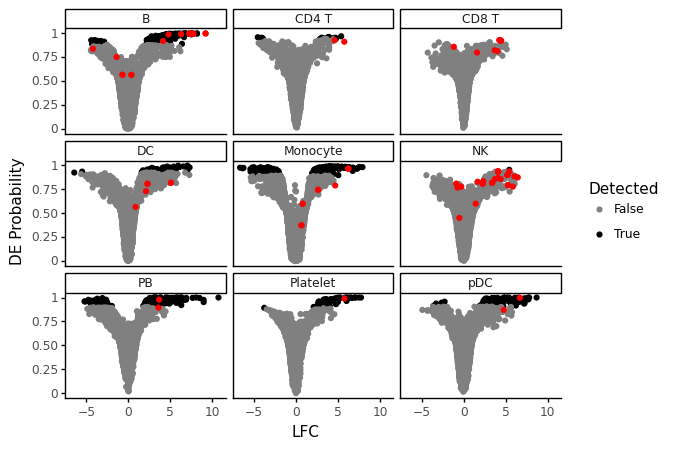

<ggplot: (8784294710173)>

In [23]:
merged_res = (
    results
    .assign(
        cell_type=lambda x: x.comparison.apply(lambda y: y.split("vs")[0].strip()),
        gene_id=lambda x: x.index
    )
    .merge(ref_data_, on=["gene_id", "cell_type"], how="left")
    .assign(
        is_marker=lambda x: ~x.cellMarker.isna()
    )
    .loc[lambda x: x.cell_type.isin(ref_data_.cell_type.unique())]
)

(
    p9.ggplot(merged_res.query("~is_marker"), p9.aes(x="lfc_median", y="proba_de", color="is_de_fdr_0.05"))
    + p9.facet_wrap("cell_type")
    + p9.geom_point()
    + p9.scale_color_cmap_d(bin_cmap)
    + p9.geom_point(merged_res.query("is_marker"), color="red")
    + p9.labs(x="LFC", y="DE Probability", color="Detected")
    + p9.theme_classic()
)

## Pairwise comparison

Using the same batch correction procedure, lvm-DE can also be used to compare two arbitrary subpopulations.
In this section, we compare B and DC cells, and compare lvm-DE's LFC estimates to fold-changes obtained using DESeq2 from a independently obtained RNA-seq dataset that serves as reference.

In [47]:
bulk_pair_url = "https://github.com/PierreBoyeau/gitdata/blob/main/lvm-DE-notebook/blish_pairs_deseq2.tsv?raw=true"
bulk_df = (
    pd.read_csv(bulk_pair_url, sep="\t")
    .assign(GS=lambda x: x.symbol)
)
bulk_df.head()

,Unnamed: 0,GSS,pval,padj,lfc,GS,label_a,label_b,pair_key,query,symbol
0,0,ENSG00000223972.5,0.699901,NaN,-1.846987,DDX11L1,B,mDC,BmDC,ENSG00000223972,DDX11L1
1,1,ENSG00000223972.5,0.434992,0.981915,2.677910,DDX11L1,B,monocytes,Bmonocytes,ENSG00000223972,DDX11L1
2,2,ENSG00000223972.5,0.493674,NaN,2.220294,DDX11L1,B,pDC,BpDC,ENSG00000223972,DDX11L1
3,3,ENSG00000223972.5,0.205831,NaN,-4.513219,DDX11L1,mDC,monocytes,mDCmonocytes,ENSG00000223972,DDX11L1
4,4,ENSG00000223972.5,0.237503,NaN,-4.035231,DDX11L1,mDC,pDC,mDCpDC,ENSG00000223972,DDX11L1


In [38]:
results_pair = model.lvm_de(
    adata=adata_[obs.Status=="Healthy"],
    idx1="cell_type == 'DC'",
    idx2="cell_type == 'B'",
    batch_correction=True,
#     pseudocounts=0,
    n_samples=20000,
    fn_kwargs=fn_kwargs,
)

INFO     Received view of anndata, making copy.                                              
DE...: 100%|██████████| 1/1 [00:09<00:00,  9.33s/it]


/data/yosef2/users/pierreboyeau/conda/envs/scvitools/lib/python3.7/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density_2d : Removed 227 rows containing non-finite values.
/data/yosef2/users/pierreboyeau/conda/envs/scvitools/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 10 rows containing missing values.


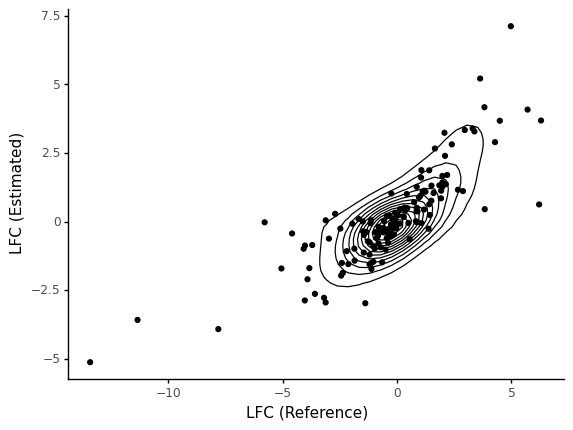

<ggplot: (8784314832209)>

In [39]:
# Merging with RNA-seq data
bulk_d = bulk_df.query("pair_key == 'BmDC'").set_index("GS")
results_pair = results_pair.join(bulk_d)

(
    p9.ggplot(results_pair, p9.aes(x="lfc", y="lfc_median"))
    + p9.geom_density_2d(levels=10)
    + p9.geom_point(results_pair.sample(frac=0.05))
    + p9.labs(x="LFC (Reference)", y="LFC (Estimated)")
    + p9.theme_classic()
)

## Obtaining inflammation markers

Finally, we aim to obtain cell-type specific inflammation markers.
To do so, we compare healthy and inflammed cells sharing the same annotation.
However, in such a case, the compared are expressed in different batches.
In such a case, we use observed batches to compute expression levels, as illustrated below.

![disjoint_batches](https://user-images.githubusercontent.com/23222597/118842110-327e3000-b8c9-11eb-8a08-8556a9d76dbb.png)

The following dataframe contains cell-type-specific inflammation markers, obtained from the [ImmGen](https://www.immgen.org/Databrowser19/Cytokines.html)
project, as well as LFC estimates.
These markers were obtained from microarray data.

In [50]:
ifn_url = "https://github.com/PierreBoyeau/gitdata/blob/main/lvm-DE-notebook/blish_data_inflammation1.tsv?raw=true"
ifn_responses = (
    pd.read_csv(ifn_url, sep="\t")
    .assign(lfc_gt=lambda x: np.log2(x.lfc_gt))
)
ifn_responses.head()

,Unnamed: 0,ProbeSetID,GeneSymbol,cell_type_name,lfc_gt,cell_type_,cell_type,gene_name
0,0,10496539,Gbp5,2 hr IFNa FoldChange in B,2.166715,B,B,GBP5
1,1,10496539,Gbp5,2 hr IFNa FoldChange in DC,3.593354,DC,DC,GBP5
2,4,10496539,Gbp5,2 hr IFNa FoldChange in NK,1.735522,NK,NK,GBP5
3,6,10496539,Gbp5,2 hr IFNa FoldChange in T4,2.715893,T4,CD4 T,GBP5
4,7,10496539,Gbp5,2 hr IFNa FoldChange in T8,2.922198,T8,CD8 T,GBP5


In [41]:
all_res = pd.DataFrame()
for ct in ifn_responses.cell_type.unique():
    print(ct)
    results = model.lvm_de(
        adata=adata_[adata_.obs.cell_type_coarse == ct],
        idx1="Status == 'COVID'",
        batch_correction=False,
        n_samples=20000,
#         pseudocounts=0.,
        fn_kwargs=fn_kwargs,
    )
    all_res = all_res.append(
        results.assign(ct=ct).reset_index(),
        ignore_index=True,
    )

B
INFO     Received view of anndata, making copy.                                              
DE...: 100%|██████████| 1/1 [00:41<00:00, 41.80s/it]
DC
INFO     Received view of anndata, making copy.                                              
DE...: 100%|██████████| 1/1 [00:38<00:00, 38.12s/it]
NK
INFO     Received view of anndata, making copy.                                              
DE...: 100%|██████████| 1/1 [00:43<00:00, 43.34s/it]
CD4 T
INFO     Received view of anndata, making copy.                                              
DE...: 100%|██████████| 1/1 [00:42<00:00, 42.91s/it]
CD8 T
INFO     Received view of anndata, making copy.                                              
DE...: 100%|██████████| 1/1 [00:42<00:00, 42.69s/it]
gd T
INFO     Received view of anndata, making copy.                                              
DE...: 100%|██████████| 1/1 [00:36<00:00, 36.66s/it]


In [42]:
all_res_ = (
    all_res
    .merge(ifn_responses, left_on=["index", "ct"], right_on=["gene_name", "cell_type"], how="left")
    .assign(is_marker=lambda x: ~x.lfc_gt.isna())
)

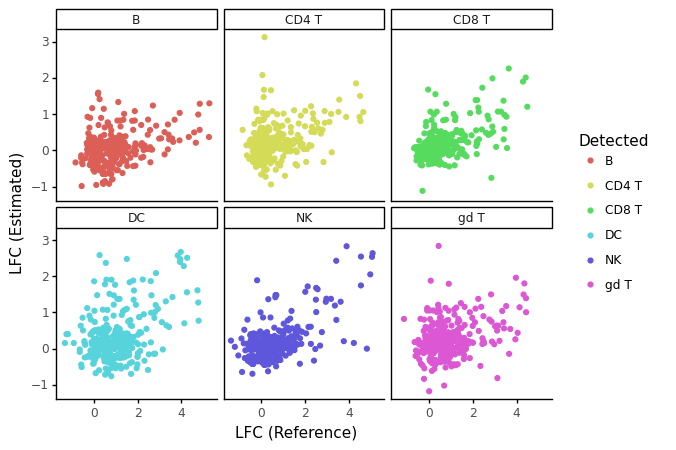

<ggplot: (8784314868309)>

In [43]:
(
    p9.ggplot(all_res_.query("is_marker"), p9.aes(x="lfc_gt", y="lfc_median", color="ct"))
    + p9.facet_wrap("ct")
    + p9.geom_point()
    + p9.labs(x="LFC (Reference)", y="LFC (Estimated)", color="Detected")
    + p9.theme_classic()
)